In [1]:
############################
# 1) Install Dependencies #
############################
!pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade transformers datasets evaluate librosa seaborn
!pip install bitsandbytes
!pip install pydub



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.7/848.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:

############################
# 2) Import Libraries     #
############################
import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:true"
import requests
import shutil
from zipfile import ZipFile
import torch
import librosa
import datasets
import evaluate
import numpy as np
import pandas as pd
from tqdm import tqdm
from datasets import load_from_disk, Dataset, DatasetDict, concatenate_datasets
from transformers import (
    Wav2Vec2ForSequenceClassification,
    Wav2Vec2Processor,
    TrainingArguments,
    Trainer,
    get_scheduler
)
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from bitsandbytes.optim import Adam8bit
from sklearn.metrics import classification_report, confusion_matrix
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
############################
# 3) Check GPU & Versions #
############################
print("Torch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("GPU available?", torch.cuda.is_available())
print("Using device:", device)
!nvidia-smi


ERROR:bitsandbytes.cextension:Could not load bitsandbytes native library: /lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /usr/local/lib/python3.11/dist-packages/bitsandbytes/libbitsandbytes_cpu.so)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/bitsandbytes/cextension.py", line 85, in <module>
    lib = get_native_library()
          ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bitsandbytes/cextension.py", line 72, in get_native_library
    dll = ct.cdll.LoadLibrary(str(binary_path))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 454, in LoadLibrary
    return self._dlltype(name)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4

Torch version: 2.6.0+cu118
GPU available? False
Using device: cpu
/bin/bash: line 1: nvidia-smi: command not found


## Data acquisition

In [3]:
urls = [
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc2.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc3.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc4.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc5.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc6.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc7.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc8.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc9.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc10.zip",
    "https://ars.els-cdn.com/content/image/1-s2.0-S0885230821001340-mmc11.zip"
]

# 2) SET UP FOLDERS
# Create root directories for your final data
os.makedirs("Healthy", exist_ok=True)
os.makedirs("MCI", exist_ok=True)
os.makedirs("AD", exist_ok=True)

# Create a temporary folder for extracted files
temp_folder = "tmp_extracted"
os.makedirs(temp_folder, exist_ok=True)

# 3) DOWNLOAD AND EXTRACT EACH ZIP
for i, url in enumerate(urls):
    zip_filename = f"downloaded_{i}.zip"   # A local name to store the downloaded file

    # Download the file
    print(f"Downloading from {url}...")
    response = requests.get(url)
    with open(zip_filename, "wb") as f:
        f.write(response.content)
    print(f"Saved {zip_filename}")

    # Extract all contents into the temp_folder
    print(f"Extracting {zip_filename}...")
    with ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(temp_folder)

    # Optionally delete the ZIP file after extraction to save space
    os.remove(zip_filename)

temp_folder = "tmp_extracted"  # your temporary extraction folder



# 4) MOVE FILES INTO THE RIGHT FOLDERS (WITH MP3 TO WAV CONVERSION)
for root, dirs, files in os.walk(temp_folder):
    for filename in files:
        full_path = os.path.join(root, filename)

        # Convert MP3 to WAV if needed
        if filename.endswith(".mp3"):
            wav_filename = filename.replace(".mp3", ".wav")
            wav_path = os.path.join(root, wav_filename)

            # Convert MP3 to WAV
            audio = AudioSegment.from_mp3(full_path)
            audio.export(wav_path, format="wav")

            # Remove the original MP3
            os.remove(full_path)

            # Update full_path to the new WAV file
            full_path = wav_path
            filename = wav_filename

        # Move to corresponding folder
        if filename.startswith("AD"):
            shutil.move(full_path, os.path.join("AD", filename))
        elif filename.startswith("MCI"):
            shutil.move(full_path, os.path.join("MCI", filename))
        elif filename.startswith("HC"):
            shutil.move(full_path, os.path.join("Healthy", filename))
        else:
            print(f"File '{filename}' doesn't match AD/MCI/HC. Skipping or placing it elsewhere.")

print("MP3 conversion and file moving completed.")


# 5) CLEAN UP
shutil.rmtree(temp_folder, ignore_errors=True)
print("Temporary folder removed.")


Saved downloaded_0.zip
Extracting downloaded_0.zip...
Saved downloaded_1.zip
Extracting downloaded_1.zip...
Saved downloaded_2.zip
Extracting downloaded_2.zip...
Saved downloaded_3.zip
Extracting downloaded_3.zip...
Saved downloaded_4.zip
Extracting downloaded_4.zip...
Saved downloaded_5.zip
Extracting downloaded_5.zip...
Saved downloaded_6.zip
Extracting downloaded_6.zip...
Saved downloaded_7.zip
Extracting downloaded_7.zip...
Saved downloaded_8.zip
Extracting downloaded_8.zip...
Saved downloaded_9.zip
Extracting downloaded_9.zip...
MP3 conversion and file moving completed.
Temporary folder removed.


In [5]:

############################
# 1) Data Preprocessing   #
############################
from transformers.modeling_outputs import SequenceClassifierOutput
#modifiedd model that adds prosodic features
class Wav2Vec2ProsodicClassifier(nn.Module):
    def __init__(self, base_model, num_labels, prosodic_dim=3):
        super().__init__()
        self.wav2vec2 = base_model  # Wav2Vec2ForSequenceClassification base model
        self.fc_prosody = nn.Linear(prosodic_dim, 16)  # Project prosodic features
        # Dynamically get the hidden size from the base model configuration
        hidden_size = self.wav2vec2.config.hidden_size
        self.fc_combined = nn.Linear(hidden_size + 16, num_labels)  # Combine Wav2Vec2 + prosody

    def forward(self, input_values, prosodic_features, attention_mask=None, labels=None, **kwargs):
      outputs = self.wav2vec2(
          input_values,
          attention_mask=attention_mask,
          output_hidden_states=True
      )
      wav_embeddings = outputs.hidden_states[-1].mean(dim=1)  # (Batch, hidden_size)
      prosodic_embeddings = self.fc_prosody(prosodic_features)  # (Batch, 16)
      combined_features = torch.cat((wav_embeddings, prosodic_embeddings), dim=-1)
      logits = self.fc_combined(combined_features)  # (Batch, num_labels)

      # Ensure logits always have a batch dimension
      if logits.dim() == 1:
          logits = logits.unsqueeze(0)

      loss = None
      if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits, labels)

      return SequenceClassifierOutput(
          loss=loss,
          logits=logits,
          hidden_states=outputs.hidden_states,
          attentions=outputs.attentions
      )


    def gradient_checkpointing_enable(self):
        self.wav2vec2.gradient_checkpointing_enable()


model_name = "jonatasgrosman/wav2vec2-large-xlsr-53-spanish"
processor = Wav2Vec2Processor.from_pretrained(model_name)
base_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/262 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-spanish and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:


#Sample weights calculations to compensate for imbalancedd dataset
num_samples_per_class = {
    0: 197,  # Healthy (HC)
    1: 90,   # MCI
    2: 74    # AD
}

# Original class counts
num_samples_per_class = {0: 197, 1: 90, 2: 74}
# Compute original class weights
total_samples = sum(num_samples_per_class.values())
num_classes = len(num_samples_per_class)
class_weights = {cls: total_samples / (num_classes * count) for cls, count in num_samples_per_class.items()}
#  Manually increase MCI weight
class_weights[1] *= 2  # Double MCI weight
#  Normalize class weights (to prevent excessive imbalance)
max_weight = max(class_weights.values())
class_weights = {cls: weight / max_weight for cls, weight in class_weights.items()}
# Convert to PyTorch tensor
device = "cuda" if torch.cuda.is_available() else "cpu"
weights_tensor = torch.tensor([class_weights[0], class_weights[1], class_weights[2]], dtype=torch.float).to(device)
# Use in CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)




ROOT_DIR = os.getcwd()
DATASET_PATH = ROOT_DIR  # Root folder where audio files are stored
OUTPUT_PATH = os.path.join(ROOT_DIR, "ProcessedFiles")
os.makedirs(OUTPUT_PATH, exist_ok=True)

LABEL_MAP = {"Healthy": 0, "MCI": 1, "AD": 2}

def load_audio(file_path, target_sr=16000):
    audio, sr = librosa.load(file_path, sr=target_sr)
    return np.array(audio, dtype=np.float32), sr  # Ensure float32 output

def preprocess_function(example):
    """Processes Wav2Vec2 inputs and extracts prosodic features."""
    audio = example["audio"]

    # Wav2Vec2 processing
    inputs = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt")

    # Extract prosodic features (without pitch)
    prosodic_features = extract_prosodic_features(example["audio"]["path"])

    # Convert prosodic features to tensor
    inputs["prosodic_features"] = torch.tensor(prosodic_features, dtype=torch.float32)
    inputs["label"] = example["label"]

    return inputs

def chunk_audio(example, max_length=16000*60):  # 60 seconds max
    audio = example["audio"]
    if len(audio) > max_length:
        example["audio"] = audio[:max_length]
    return preprocess_function(example)


In [7]:

audio_files = []
labels = []

for category in LABEL_MAP.keys():
    category_path = os.path.join(DATASET_PATH, category)
    if not os.path.exists(category_path):
        continue
    for file in os.listdir(category_path):
        if file.endswith(".wav"):
            audio_files.append(os.path.join(category_path, file))
            labels.append(LABEL_MAP[category])

data_df = pd.DataFrame({"file_path": audio_files, "label": labels})



## Analysis of audio duration and class dependency

Mean Duration: 48.17 seconds
Standard Deviation: 24.93 seconds


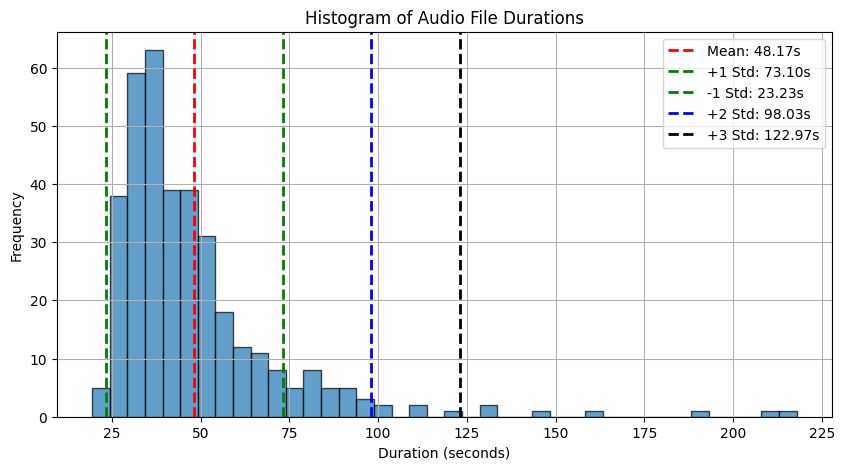

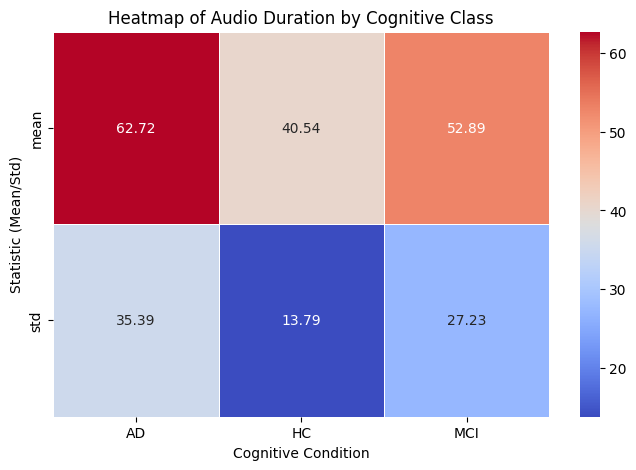

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to compute audio duration
def compute_audio_length(file_path):
    y, sr = librosa.load(file_path, sr=None)  # Load audio
    return len(y) / sr  # Compute duration in seconds

# Apply function to get durations
data_df["duration"] = data_df["file_path"].apply(compute_audio_length)

# Compute statistics
mean_duration = data_df["duration"].mean()
std_duration = data_df["duration"].std()

# Print statistics
print(f"Mean Duration: {mean_duration:.2f} seconds")
print(f"Standard Deviation: {std_duration:.2f} seconds")

# Plot a single histogram for all durations
plt.figure(figsize=(10, 5))
plt.hist(data_df["duration"], bins=40, edgecolor="black", alpha=0.7)
plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_duration:.2f}s")
plt.axvline(mean_duration + std_duration, color='green', linestyle='dashed', linewidth=2, label=f"+1 Std: {mean_duration + std_duration:.2f}s")
plt.axvline(mean_duration - std_duration, color='green', linestyle='dashed', linewidth=2, label=f"-1 Std: {mean_duration - std_duration:.2f}s")
plt.axvline(mean_duration + 2*std_duration, color='blue', linestyle='dashed', linewidth=2, label=f"+2 Std: {mean_duration + 2*std_duration:.2f}s")
plt.axvline(mean_duration + 3*std_duration, color='black', linestyle='dashed', linewidth=2, label=f"+3 Std: {mean_duration + 3*std_duration:.2f}s")

plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Histogram of Audio File Durations")
plt.legend()
plt.grid(True)
plt.show()




# Function to compute audio duration
def compute_audio_length(file_path):
    y, sr = librosa.load(file_path, sr=None)  # Load audio
    return len(y) / sr  # Compute duration in seconds

# Extract class labels from file names
def extract_class(file_path):
    filename = file_path.split("/")[-1]  # Extract filename
    if filename.startswith("HC"):
        return "HC"  # Healthy
    elif filename.startswith("MCI"):
        return "MCI"  # Mild Cognitive Impairment
    elif filename.startswith("AD"):
        return "AD"  # Alzheimer's
    return "Unknown"

# Apply functions to DataFrame
data_df["duration"] = data_df["file_path"].apply(compute_audio_length)
data_df["class"] = data_df["file_path"].apply(extract_class)

# Compute mean and std deviation of duration per class
heatmap_data = data_df.groupby("class")["duration"].agg(["mean", "std"]).reset_index()

# Convert to a matrix format suitable for a heatmap
heatmap_matrix = heatmap_data.set_index("class").T

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Heatmap of Audio Duration by Cognitive Class")
plt.xlabel("Cognitive Condition")
plt.ylabel("Statistic (Mean/Std)")
plt.show()



In [ ]:



def extract_prosodic_features(audio_path):
    """Extracts prosodic features: pauses and speech rate (no pitch)."""
    y, sr = librosa.load(audio_path, sr=16000)
    # Compute energy for silence detection
    energy = librosa.feature.rms(y=y)
    silence_threshold = np.percentile(energy, 10)  # 10th percentile as threshold
    pauses = np.where(energy < silence_threshold)[1]
    num_pauses = len(pauses)
    total_pause_duration = len(pauses) / sr  # Convert to seconds
    # Speech rate (words per second)
    speech_rate = librosa.beat.tempo(y=y, sr=sr)[0] / 60  # Convert BPM to words per second
    return np.array([num_pauses, total_pause_duration, speech_rate], dtype=np.float32)



# Splitting dataset
train_files, test_files, train_labels, test_labels = train_test_split(
    data_df["file_path"], data_df["label"],
    test_size=0.2, stratify=data_df["label"], random_state=42
)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels,
    test_size=0.1, stratify=train_labels, random_state=42
)

def process_data(files, labels):
    data = []
    for file, label in tqdm(zip(files, labels), total=len(files)):
        audio, sr = load_audio(file)
        data.append({
            "audio": {
                "array": np.array(audio, dtype=np.float32),
                "sampling_rate": sr,
                "path": file  # Save file path for prosodic feature extraction if needed
            },
            "label": label
        })
    return data

train_data = process_data(train_files, train_labels)
val_data = process_data(val_files, val_labels)
test_data = process_data(test_files, test_labels)

dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "validation": Dataset.from_list(val_data),
    "test": Dataset.from_list(test_data),
})

dataset = dataset.map(chunk_audio)
dataset.save_to_disk(OUTPUT_PATH)
print(f"Dataset saved to {OUTPUT_PATH}")



In [ ]:
############################
# 2) Load Dataset          #
############################

dataset = load_from_disk(OUTPUT_PATH)


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label', 'input_values', 'attention_mask', 'prosodic_features'],
        num_rows: 259
    })
    validation: Dataset({
        features: ['audio', 'label', 'input_values', 'attention_mask', 'prosodic_features'],
        num_rows: 29
    })
    test: Dataset({
        features: ['audio', 'label', 'input_values', 'attention_mask', 'prosodic_features'],
        num_rows: 73
    })
})

In [ ]:
############################
# 2) Load Model            #
############################
model = Wav2Vec2ProsodicClassifier(base_model, num_labels=3)
model.gradient_checkpointing_enable()
optimizer = Adam8bit(model.parameters(), lr=2e-5)



In [ ]:


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    report = classification_report(labels, predictions, target_names=["Healthy", "MCI", "AD"], output_dict=True)

    print("Classification Report:\n", classification_report(labels, predictions, target_names=["Healthy", "MCI", "AD"]))

    return {
        "accuracy": report["accuracy"],
        "f1_macro": report["macro avg"]["f1-score"],
        "f1_healthy": report["Healthy"]["f1-score"],
        "f1_mci": report["MCI"]["f1-score"],
        "f1_ad": report["AD"]["f1-score"],
    }

############################
# 3) Data Collator         #
############################

def data_collator_fn(features):
    waveforms = [torch.tensor(f["audio"]["array"]) for f in features]
    prosodic_features = torch.stack([
        torch.tensor(f["prosodic_features"], dtype=torch.float) for f in features
    ])  # Now each prosodic_features is converted to a tensor
    labels = torch.tensor([f["label"] for f in features])

    input_values = pad_sequence(waveforms, batch_first=True, padding_value=0)

    inputs = processor(
        input_values.numpy(),
        sampling_rate=16000,
        padding=True,
        return_tensors="pt"
    )

    inputs["labels"] = labels
    inputs["prosodic_features"] = prosodic_features  # Add prosodic features

    return inputs



############################
# 4) Training Arguments   #
############################

training_args = TrainingArguments(
    output_dir="./wav2vec2_classification",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=5,
    weight_decay=0.2,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=True,
    remove_unused_columns=False,
    gradient_accumulation_steps=4,
    load_best_model_at_end=True,
)

class CustomTrainer(Trainer):
    def __init__(self, model, args, train_dataset, eval_dataset, data_collator, optimizers, class_weights, compute_metrics=None):
        super().__init__(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        optimizers=optimizers,
        compute_metrics=compute_metrics
        )
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)  # Set the weighted loss


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        prosodic_features = inputs.pop("prosodic_features")
        outputs = model(input_values=inputs["input_values"], prosodic_features=prosodic_features, labels=labels)
        logits = outputs.logits
        # Use the weighted loss function
        loss = self.criterion(logits, labels)
        return (loss, outputs) if return_outputs else loss

    def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
        labels = inputs.pop("labels", None)  # Remove labels from inputs
        prosodic_features = inputs.pop("prosodic_features")

        with torch.no_grad():
            outputs = model(input_values=inputs["input_values"], prosodic_features=prosodic_features, labels=labels)

        loss = outputs.loss if outputs.loss is not None else None
        logits = outputs.logits

        if prediction_loss_only:
            return (loss, None, None)

        return (loss, logits, labels)

# Define the learning rate scheduler
num_training_steps = training_args.num_train_epochs * len(dataset["train"]) // training_args.gradient_accumulation_steps

lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=100,  # Gradual warmup phase
    num_training_steps=num_training_steps
)

# Update Trainer initialization
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator_fn,
    optimizers=(optimizer, lr_scheduler),
    class_weights=weights_tensor  # Pass class weights
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Healthy,F1 Mci,F1 Ad
1,21.488400,3.569229,0.206897,0.114286,0.000000,0.000000,0.342857
2,14.693300,2.650622,0.310345,0.229032,0.300000,0.000000,0.387097
3,11.493400,1.848818,0.586207,0.326829,0.780488,0.000000,0.200000
4,8.473400,1.264345,0.655172,0.538462,0.800000,0.615385,0.200000


Classification Report:
               precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        16
         MCI       0.00      0.00      0.00         7
          AD       0.21      1.00      0.34         6

    accuracy                           0.21        29
   macro avg       0.07      0.33      0.11        29
weighted avg       0.04      0.21      0.07        29



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.75      0.19      0.30        16
         MCI       0.00      0.00      0.00         7
          AD       0.24      1.00      0.39         6

    accuracy                           0.31        29
   macro avg       0.33      0.40      0.23        29
weighted avg       0.46      0.31      0.25        29



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.64      1.00      0.78        16
         MCI       0.00      0.00      0.00         7
          AD       0.25      0.17      0.20         6

    accuracy                           0.59        29
   macro avg       0.30      0.39      0.33        29
weighted avg       0.40      0.59      0.47        29



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.64      0.88      0.74        16
         MCI       1.00      0.14      0.25         7
          AD       0.17      0.17      0.17         6

    accuracy                           0.55        29
   macro avg       0.60      0.39      0.38        29
weighted avg       0.63      0.55      0.50        29

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.74      0.88      0.80        16
         MCI       0.67      0.57      0.62         7
          AD       0.25      0.17      0.20         6

    accuracy                           0.66        29
   macro avg       0.55      0.54      0.54        29
weighted avg       0.62      0.66      0.63        29



TrainOutput(global_step=160, training_loss=13.140212440490723, metrics={'train_runtime': 1775.7978, 'train_samples_per_second': 0.729, 'train_steps_per_second': 0.09, 'total_flos': 0.0, 'train_loss': 13.140212440490723, 'epoch': 4.861538461538462})

In [ ]:

torch.save(model.state_dict(), "./wav2vec2_classification/model.pth")
processor.save_pretrained("./wav2vec2_classification")

print("Training complete! Model saved to ./wav2vec2_classification")


Training complete! Model saved to ./wav2vec2_classification


In [ ]:
!zip -r wav2vec2_classification.zip wav2vec2_classification

  adding: wav2vec2_classification/ (stored 0%)
  adding: wav2vec2_classification/checkpoint-160/ (stored 0%)
  adding: wav2vec2_classification/checkpoint-160/training_args.bin (deflated 52%)
  adding: wav2vec2_classification/checkpoint-160/scaler.pt (deflated 60%)
  adding: wav2vec2_classification/checkpoint-160/model.safetensors (deflated 7%)
  adding: wav2vec2_classification/checkpoint-160/rng_state.pth (deflated 25%)
  adding: wav2vec2_classification/checkpoint-160/scheduler.pt (deflated 54%)
  adding: wav2vec2_classification/checkpoint-160/trainer_state.json (deflated 75%)
  adding: wav2vec2_classification/checkpoint-160/optimizer.pt (deflated 12%)
  adding: wav2vec2_classification/tokenizer_config.json (deflated 71%)
  adding: wav2vec2_classification/checkpoint-66/ (stored 0%)
  adding: wav2vec2_classification/checkpoint-66/training_args.bin (deflated 52%)
  adding: wav2vec2_classification/checkpoint-66/scaler.pt (deflated 60%)
  adding: wav2vec2_classification/checkpoint-66/model

In [ ]:
from google.colab import files
files.download("wav2vec2_classification.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>